In [ ]:
import pickle
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Import & Prepare data

In [3]:
data = pd.read_csv('../data/covid19_metabolites.csv')

In [4]:
data

,SubjectId,Group,Sex,Age,Creatinine,Glycine,Alanine,Serine,Proline,Valine,...,Hydroxybutyrylcarnitine,Octanoylcarnitine,Decadienoylcarnitine,Decenoylcarnitine,Decanoylcarnitine,Dodecenoylcarnitine,Dodecanoylcarnitine,Hexadecanoylcarnitine,Octadecadienylcarnitine,Octadecenoylcarnitine
0,CV19-0007A,Control,Female,68.0,166.0,230.0,236.0,117.0,151.0,170.0,...,0.2001,0.1216,0.0789,0.2072,0.2437,0.1584,0.1266,0.2262,0.1301,0.2876
1,CV19-0071A,Control,Female,57.0,67.0,233.0,343.0,89.2,151.0,145.0,...,0.0741,0.2256,0.0695,0.2310,0.3679,0.1526,0.1123,0.1534,0.1190,0.2378
2,CV19-0079A,Control,Male,39.0,69.2,250.0,371.0,129.0,175.0,207.0,...,0.0416,0.0951,0.0996,0.1439,0.1661,0.0977,0.0860,0.2005,0.1604,0.3066
3,CV19-0118A,Control,Female,40.0,54.2,190.0,415.0,103.0,165.0,149.0,...,0.0291,0.2326,0.0705,0.2509,0.3039,0.1262,0.0775,0.0983,0.0702,0.1598
4,CV19-0125A,Control,Female,40.0,63.1,189.0,373.0,94.5,167.0,158.0,...,0.0592,0.1857,0.0709,0.2856,0.3549,0.1938,0.1446,0.1281,0.0998,0.2283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,CV19-0830A,Covid,Female,51.0,89.9,117.0,273.0,58.3,125.0,245.0,...,0.1570,0.1348,0.1569,0.2186,0.4441,0.1232,0.0938,0.1326,0.1060,0.2467
227,CV19-0833A,Covid,Male,65.0,112.0,162.0,497.0,88.7,111.0,275.0,...,0.0738,0.2481,0.1557,0.3837,0.6554,0.1521,0.0903,0.1158,0.0797,0.1718
228,CV19-0834A,Covid,Male,66.0,114.0,181.0,574.0,90.8,206.0,247.0,...,0.1481,0.2395,0.1776,0.3464,0.3441,0.2043,0.1211,0.1922,0.1354,0.3183
229,CV19-0932A,Covid,Male,53.0,68.3,321.0,551.0,163.0,219.0,552.0,...,1.0753,0.3273,0.1791,0.4793,0.5729,0.2027,0.1921,0.1784,0.1350,0.3122


### Encoding the target varable

In [5]:
# Split features
X = data.iloc[:, 2:]

In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# encode labels
Y = label_encoder.fit_transform(data['Group'])

In [7]:
dict(zip(list(set(Y)),label_encoder.inverse_transform(list(set(Y)))))

{0: 'Control', 1: 'Covid', 2: 'Recovered'}

### One hot encoding

In [8]:
X = pd.get_dummies(X, columns=['Sex'], prefix='Sex',dtype = float)

In [9]:
X.iloc[:,108:]

,Sex_Female,Sex_Male
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
226,1.0,0.0
227,0.0,1.0
228,0.0,1.0
229,0.0,1.0


### Train/Test split

In [10]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)  # 80% Train, 20% Temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)  # 10% Val, 10% Test

In [11]:
Y_test

array([0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1,
       2, 1])

In [12]:
print('Train Size:', len(X_train))
print('Test Size:',len(X_val))
print('Test Size:',len(X_test))
# print('Train shape:', X_train.shape, Y_train.shape)
# print('Test shape:', X_test.shape, Y_test.shape)

Train Size: 184
Test Size: 23
Test Size: 24


### Normalize data

In [13]:
# Normalize the data
scaler = StandardScaler()
X_train.iloc[:, :-2] = scaler.fit_transform(X_train.iloc[:, :-2])  # Normalize all metabolite and age columns
X_val.iloc[:, :-2] = scaler.transform(X_val.iloc[:, :-2])
X_test.iloc[:, :-2] = scaler.transform(X_test.iloc[:, :-2])

In [14]:
# Y_train_onehot = to_categorical(Y_train, num_classes=3)
# Y_test_onehot = to_categorical(Y_test, num_classes=3)

### Prepare datasets

In [15]:
# Prepare Dataset
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

In [16]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Convolutional neural network

In [34]:
class MetCNN(nn.Module):
    def __init__(self, input_size):
        super(MetCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, 3)  # Output classes
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, 10, 11)  # Reshape input
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [35]:
# Training the Model
model = MetCNN(input_size=110)
# class_weights = torch.tensor([2.0, 1.5, 2.0])  # Example weights for Control, Covid, Recovered
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [36]:

# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [37]:
# Training Loop
for epoch in range(50):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_accuracy = correct_train / total_train
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)
            
            # Collect predictions and labels for evaluation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    val_accuracy = correct_val / total_val
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 1.0702, Val Loss: 1.0672, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 2, Train Loss: 1.0641, Val Loss: 1.0608, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 3, Train Loss: 1.0591, Val Loss: 1.0559, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 4, Train Loss: 1.0536, Val Loss: 1.0513, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 5, Train Loss: 1.0498, Val Loss: 1.0469, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 6, Train Loss: 1.0457, Val Loss: 1.0421, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 7, Train Loss: 1.0402, Val Loss: 1.0368, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 8, Train Loss: 1.0364, Val Loss: 1.0308, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 9, Train Loss: 1.0308, Val Loss: 1.0242, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 10, Train Loss: 1.0239, Val Loss: 1.0164, Train Accuracy: 0.6250, Val Accuracy: 0.6087
Epoch 11, Train Loss: 1.0163, Val Loss: 1.0074, Train Accuracy: 0.6250, Val Acc

In [38]:
print("\nFinal Evaluation on Validation Set")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Control', 'Covid', 'Recovered']))


Final Evaluation on Validation Set
Classification Report:
              precision    recall  f1-score   support

     Control       0.00      0.00      0.00         4
       Covid       0.61      1.00      0.76        14
   Recovered       0.00      0.00      0.00         5

    accuracy                           0.61        23
   macro avg       0.20      0.33      0.25        23
weighted avg       0.37      0.61      0.46        23



/opt/miniconda3/envs/nndl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/nndl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/nndl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


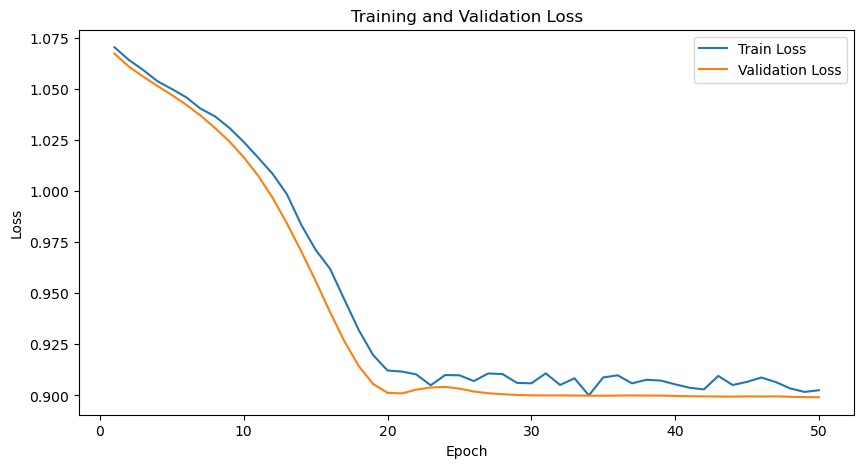

In [39]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

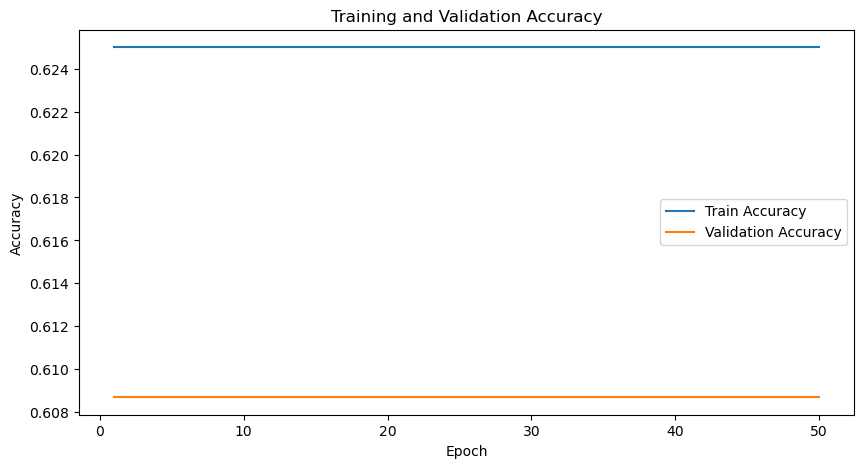

In [40]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

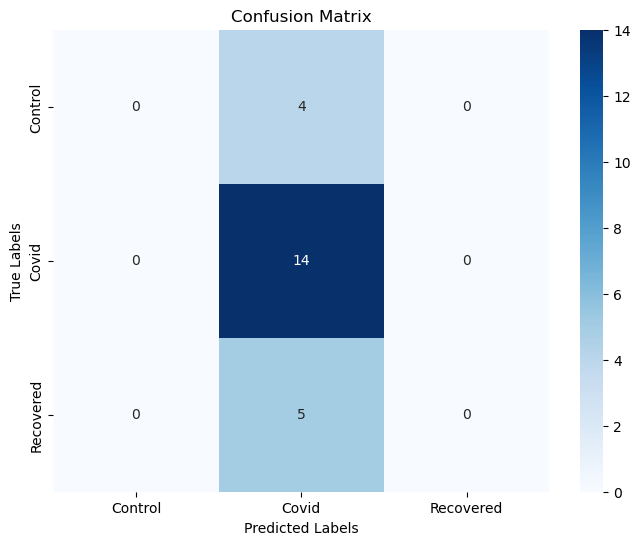

In [41]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Covid', 'Recovered'], yticklabels=['Control', 'Covid', 'Recovered'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()